In [2]:
## in this notebook i derive the time-series from a netcdf file (hourly)
# following this tutorial: 
# https://docs.xarray.dev/en/stable/user-guide/time-series.html


# ERA5 hourly data on single levels from 1979 to present

In [3]:
# Reanalysis
# Variable: 2m temperature
#           Total precipitation 
#           SW radiation (= Surface net solar radiation, clear sky)
# Year: 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022
# Month: January, February, March, April, May, June, July, August, September, October, November, December
# Day: 01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12, 13, 14, 15, 
     # 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31
# Time: 00:00, 01:00, 02:00, 03:00, 04:00, 05:00, 06:00, 07:00, 08:00, 09:00, 10:00, 11:00, 12:00, 
    # 13:00, 14:00, 15:00, 16:00, 17:00, 18:00, 19:00, 20:00, 21:00, 22:00, 23:00
# Sub-region extraction: North 28.25°, West 84.75°, South 27.75°, East 85.25°

In [4]:
# what is going on: 

# 1. open data: 
# 2. select coordinates of interest (maybe spatially avaraged for the downloaded domain) 
# 3. convert to houtly time-series 
# 4. create a table (same as climate.met file)
# 5. add the timeseries stuff to it with the timestamp 

# so in the end the table should look like the climate.met file: 
#          D   (timestamp: 1999-10-01 00:00:00)
#          Pr  (precipitation)
#          Ta  (air temperature)
#          Rsw (shortwave radiation)
#          N   (cloud cover)  


In [5]:
import xarray as xr
import pandas as pd
import datetime
import matplotlib.pyplot as plt

## only one point

## langtang-ish area (28, 25)

In [5]:
# open data 
t2m_langt  = xr.open_dataset('1_langtang/adaptor.mars.internal-1648496947.940424-8340-10-354dbfbd-8635-4aff-bcab-236ad5fab0af.nc')
ssrc_langt = xr.open_dataset('1_langtang/adaptor.mars.internal-1648500643.848671-511-11-aba2ebb0-cfe1-4202-8470-54e523436f34.nc')
tcc_langt  = xr.open_dataset('1_langtang/adaptor.mars.internal-1648509774.0260122-30137-4-1ce4a075-dd4e-4a65-8a32-727865323bf3.nc')
tp_langt   = xr.open_dataset('1_langtang/adaptor.mars.internal-1648499097.5800622-12842-11-067449ce-22b1-443a-a8b1-57bdcb61ffb7.nc')

In [6]:
# t2m_langt.longitude.values
# tcc_langt.longitude.values

# tcc_langt.expver.values
# tcc_langt.expver.values

In [7]:
# tcc_langt

In [8]:
# merge into one dataset:
# tutorial: https://docs.xarray.dev/en/stable/user-guide/combining.html

# everything excl. precipitation 

langt = xr.merge([t2m_langt,tp_langt, ssrc_langt, tcc_langt]) 
# langt = xr.combine_by_coords([t2m_langt,tp_langt, ssrc_langt, tcc_langt]) 

In [9]:
# langt
# langt

# longitude = 85
# latitude = 28

In [10]:
# select only one grid cell:
# tutorial: https://docs.xarray.dev/en/latest/user-guide/indexing.html

langt_point = langt.sel(longitude=85, latitude=28, method='nearest')
# langt_point

In [11]:
# to time-series table

langt_point_df = langt_point.to_dataframe()

In [12]:
# type(langt_point_df)
langt_point_df = langt_point_df.reset_index()

In [13]:
# drop na values from "expver" dimention 
langt_point_df = langt_point_df[langt_point_df.expver == 1]

In [14]:
# delete values that are after Jan 1st 2022 (nan values at the tail of the df)
langt_point_df = langt_point_df[langt_point_df.time < '2022-01-01 00:00:00']

In [15]:
# convert units and make sure columns look the way they should

#delete expver column
langt_point_df = langt_point_df.drop(['expver'], axis = 1)

#convert temperature K to C
langt_point_df['t2m']=langt_point_df.t2m-273.15

# precipotation m to mm 
langt_point_df['tp']=langt_point_df.tp * 1000

# radiation j/m2 to w/m2
langt_point_df['ssrc'] = langt_point_df.ssrc / 3600

In [16]:
# langt_point_df
# langt_point_df.set_index('time')

In [17]:
# langt_point_df.ssrc[:100].plot()
# langt_point_df.tcc[:100].plot()

In [18]:
df = langt_point_df[:100]

Text(0, 0.5, 'tcc')

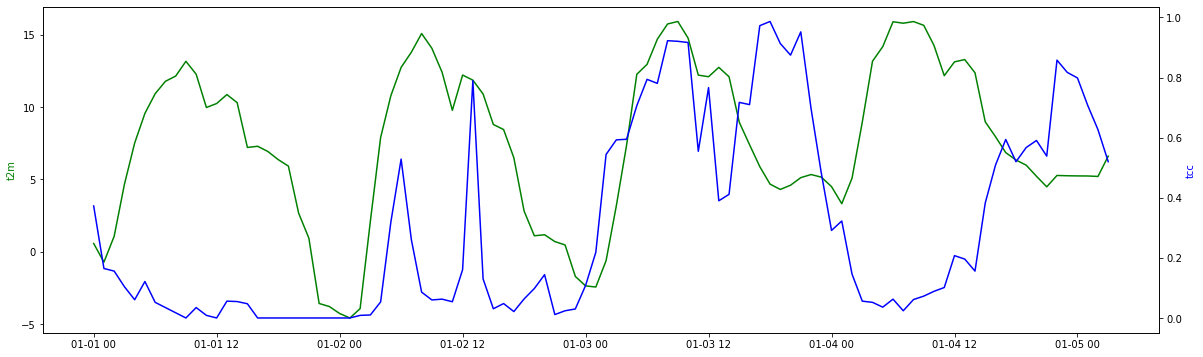

In [19]:
fig, ax1 = plt.subplots(figsize = (20,6))

ax2 = ax1.twinx()
ax1.plot(df.time, df.t2m, 'g-')
ax2.plot(df.time, df.tcc, 'b-')


ax1.set_ylabel('t2m', color='g')
ax2.set_ylabel('tcc', color='b')

In [20]:
# rename columns 
langt_point_df = langt_point_df.rename(columns = {'time': 'D', 't2m': 'Ta', 'tp':'Pr', 'ssrc':'Rsw', 'tcc': 'N'})

# drop columns that are not needed 
langtang_climate = langt_point_df.drop(['longitude', 'latitude'], axis = 1)
# langtang_climate.set_index('D')

# rearrange columns
langtang_climate = langtang_climate[['D', 'Pr','Ta', 'Rsw', 'N']]

In [22]:
# final time-series table to csv 
# pandas.DataFrame.to_csv

langtang_climate.to_csv('1_langtang/climate_langtang.met', sep ='\t', index=False)
# df.to_csv('Students.csv', sep ='\t')


In [42]:
# langtang_climate_table = pd.read_csv('langtang/climate.met', sep ='\t')
# langtang_climate_table

## ladakh-ish area (34, 77)

In [25]:
t2m_lad   = xr.open_dataset('2_ladakh/adaptor.mars.internal-1648523859.612099-21616-13-ac917b2a-7a7e-4620-a4cf-c23a631fa132.nc')
tp_lad    = xr.open_dataset('2_ladakh/adaptor.mars.internal-1648536360.0315216-1453-17-d0928c51-df02-4233-ae69-f76e34e7ed29.nc')
tcc_lad   = xr.open_dataset('2_ladakh/adaptor.mars.internal-1648537623.1678417-21616-14-5eb36abb-c20e-4b47-8d47-1ab6d09320fe.nc')
ssrc_lad  = xr.open_dataset('2_ladakh/adaptor.mars.internal-1648537949.6142147-15341-12-f8202042-8eb9-41ee-a6eb-4a55688e1edc.nc')


### plot t2m to see if its is reasonable (seems like its not?) 

In [26]:
# merge into one dataset:
lad = xr.merge([t2m_lad, tp_lad, ssrc_lad, tcc_lad])

# select only one grid cell:
lad_point = lad.sel(longitude=76.75, latitude=34.25, method='nearest')

In [27]:
# to time-series table
lad_point_df = lad_point.to_dataframe()


In [28]:
# type(langt_point_df)
lad_point_df = lad_point_df.reset_index()

In [29]:
# drop na values from "expver" dimention 
lad_point_df = lad_point_df[lad_point_df.expver == 1]

# delete values that are after Jan 1st 2022 (nan values at the tail of the df)
lad_point_df = lad_point_df[lad_point_df.time < '2022-01-01 00:00:00']

In [30]:
lad_point_df.tail()

,time,expver,longitude,latitude,t2m,tp,ssrc,tcc
210374,2021-12-31 19:00:00,1,76.75,34.25,252.777863,4.549511e-07,0.0,0.940000
210376,2021-12-31 20:00:00,1,76.75,34.25,251.311646,2.328306e-10,0.0,0.742405
210378,2021-12-31 21:00:00,1,76.75,34.25,250.870804,2.328306e-10,0.0,0.422337
210380,2021-12-31 22:00:00,1,76.75,34.25,251.245178,2.328306e-10,0.0,0.216029
210382,2021-12-31 23:00:00,1,76.75,34.25,250.721252,2.328306e-10,0.0,0.203485


In [31]:
# convert units and make sure columns look the way they should

#delete expver column
lad_point_df = lad_point_df.drop(['expver'], axis = 1)

#convert temperature K to C
# lad_point_df['t2m']=lad_point_df.t2m-273.15

# precipotation m to mm 
lad_point_df['tp']=lad_point_df.tp * 1000

# radiation j/m2 to w/m2
lad_point_df['ssrc'] = lad_point_df.ssrc / 3600

In [32]:
# lad_point_df
df = lad_point_df[100:300]

Text(0, 0.5, 'ssrc')

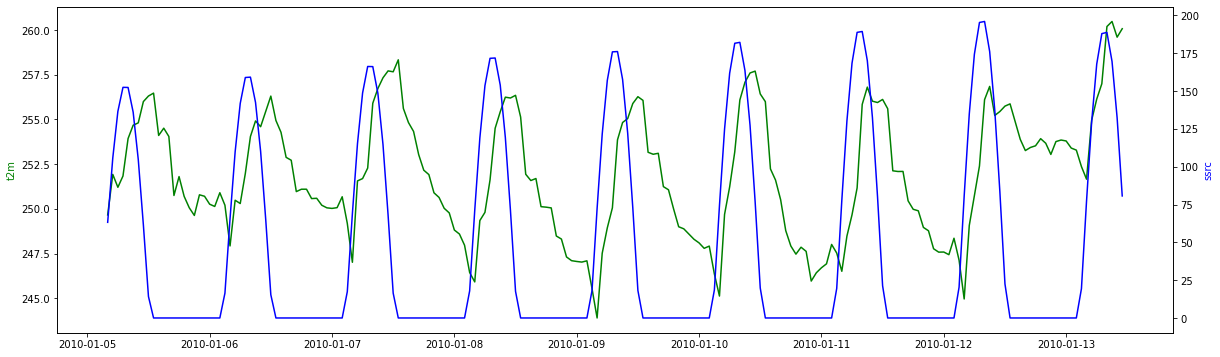

In [34]:
fig, ax1 = plt.subplots(figsize = (20,6))

ax2 = ax1.twinx()
ax1.plot(df.time, df.t2m, 'g-')
ax1.set_ylabel('t2m', color='g')

ax2.plot(df.time, df.ssrc, 'b-')
ax2.set_ylabel('ssrc', color='b')

In [35]:
# rename columns 
lad_point_df = lad_point_df.rename(columns = {'time': 'D', 't2m': 'Ta', 'tp':'Pr', 'ssrc':'Rsw', 'tcc': 'N'})

# drop columns that are not needed 
ladakh_climate = lad_point_df.drop(['longitude', 'latitude'], axis = 1)
# ladakh_climate.set_index('D')

# rearrange columns
ladakh_climate = ladakh_climate[['D', 'Pr','Ta', 'Rsw', 'N']]

In [37]:
# final time-series table to csv 
# pandas.DataFrame.to_csv

# ladakh_climate.to_csv('2_ladakh/ladakh_climate.met', sep ='\t', index=False)
# df.to_csv('Students.csv', sep ='\t')



In [ ]:
# ladakh_climate.to_csv('ladakh/Climate.met')

## tibet-ish area (29, 87)

In [41]:
ssrc_tibet = xr.open_dataset('3_tibet/adaptor.mars.internal-1648559604.8203707-18400-3-a84525fc-663a-49d0-91de-3da26dfb1426.nc')
t2m_tibet = xr.open_dataset('3_tibet/adaptor.mars.internal-1648728616.9103472-29343-11-e57db3f0-9a75-4438-abd7-f19b3d86b2b9.nc')
tp_tibet = xr.open_dataset('3_tibet/adaptor.mars.internal-1648810426.1997979-17687-5-d0b406c2-7591-4edd-a71e-18f7f66e818d.nc')

tcc_tibet = xr.open_dataset('3_tibet/adaptor.mars.internal-1649067878.6161792-14194-13-a04a955c-c0ac-43a5-ac36-0fb69c5cae66.nc')


In [42]:
# tcc

In [43]:
# merge into one dataset:
tibet = xr.merge([ssrc_tibet, t2m_tibet, tp_tibet, tcc_tibet])

# select only one grid cell:
tibet_point = lad.sel(longitude=87, latitude=29, method='nearest')

In [44]:
# to time-series table
tibet_point_df = tibet_point.to_dataframe()


In [45]:
# type(langt_point_df)
tibet_point_df = tibet_point_df.reset_index()

In [46]:
# drop na values from "expver" dimention 
tibet_point_df = tibet_point_df[tibet_point_df.expver == 1]

# delete values that are after Jan 1st 2022 (nan values at the tail of the df)
tibet_point_df = tibet_point_df[tibet_point_df.time < '2022-01-01 00:00:00']

In [47]:
# convert units and make sure columns look the way they should

#delete expver column
tibet_point_df = tibet_point_df.drop(['expver'], axis = 1)

#convert temperature K to C
tibet_point_df['t2m']=tibet_point_df.t2m-273.15

# precipotation m to mm 
tibet_point_df['tp']=tibet_point_df.tp * 1000

# radiation j/m2 to w/m2
tibet_point_df['ssrc'] = tibet_point_df.ssrc / 3600

In [48]:
# rename columns 
tibet_point_df = tibet_point_df.rename(columns = {'time': 'D', 't2m': 'Ta', 'tp':'Pr', 'ssrc':'Rsw', 'tcc': 'N'})

# drop columns that are not needed 
tibet_climate = tibet_point_df.drop(['longitude', 'latitude'], axis = 1)
# ladakh_climate.set_index('D')

# rearrange columns
tibet_climate = tibet_climate[['D', 'Pr','Ta', 'Rsw', 'N']]

<AxesSubplot:>

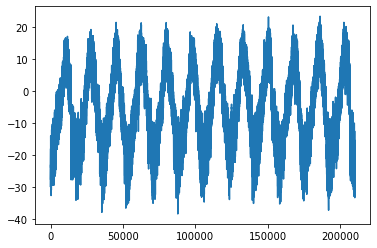

In [53]:
tibet_climate.Ta.plot()#head()

In [55]:
# final time-series table to csv 
# pandas.DataFrame.to_csv

# tibet_climate.to_csv('3_tibet/tibet_climate.met', sep ='\t', index=False)

### random changes in the climate situation


In [18]:
climate_original = pd.read_table('4_random/climate.met', sep = '\t')

In [24]:
random_climate = climate_original 

In [25]:
random_climate.Pr = random_climate.Pr + 100
random_climate.Ta = random_climate.Ta + 10


In [22]:
# climate_original

In [26]:
# random_climate.to_csv('4_random/random_climate.met', sep ='\t', index=False)

## average value for the all downloaded gridcells
### (x.75 - x.25, y.75 - y.25) 